In [35]:
from transformers import AutoConfig,AutoModel,AutoTokenizer,AdamW,get_linear_schedule_with_warmup,logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,SequentialSampler,RandomSampler,DataLoader

import pandas as pd

# 导入transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


# 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# 常用包
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm
import json
import random
import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [36]:
torch.cuda.is_available()

True

In [37]:
!nvidia-smi

Fri Oct 15 21:23:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:41:00.0 Off |                  N/A |
| 30%   28C    P8    17W / 350W |   7071MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
# initialize seeds
RANDOM_SEED = 42
def set_random_seed(seed = 10,deterministic=False,benchmark=False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
    if benchmark:
        torch.backends.cudnn.benchmark = True

set_random_seed(RANDOM_SEED)

In [39]:
file_path = "artpedia.json"
with open(file_path, 'r') as f:
    artpedia = json.load(f)

In [40]:
visual_sents = []
context_sents = []

for ind in artpedia:
    visuals = artpedia[ind]['visual_sentences']
    contexts = artpedia[ind]['contextual_sentences']
    visual_sents.extend(visuals)
    context_sents.extend(contexts)

visual_df = pd.DataFrame({"sentence": visual_sents, "category": "visual"})
context_df = pd.DataFrame({"sentence": context_sents, "category": "contextual"})

des_df = pd.concat((visual_df, context_df), axis=0)
pd.concat((des_df.head(3), des_df.tail(2)))

,sentence,category
0,"It is also stylistically earlier to that work,...",visual
1,The throne is similar to the Maestà painted by...,visual
2,The painting depicts the Virgin and Child enth...,visual
19037,It is kept at The Broad in Los Angeles.,contextual
19038,The painting was made using oil on canvas and ...,contextual


In [41]:
des_df = pd.concat([des_df.iloc[:2000], des_df.iloc[-2000:]])
# des_df

In [42]:
des_df["category"].value_counts()

contextual    2000
visual        2000
Name: category, dtype: int64

In [43]:
id2label = dict(enumerate(des_df.category.unique()))
label2id = {v: k for k, v in id2label.items()}

des_df['label'] = des_df['category'].map(label2id)
pd.concat((des_df.head(3), des_df.tail(2)))

,sentence,category,label
0,"It is also stylistically earlier to that work,...",visual,0
1,The throne is similar to the Maestà painted by...,visual,0
2,The painting depicts the Virgin and Child enth...,visual,0
19037,It is kept at The Broad in Los Angeles.,contextual,1
19038,The painting was made using oil on canvas and ...,contextual,1


In [44]:
start = time.time()

# tokenizer
PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

end = time.time()
print((end-start))

tokenizer

7.370779991149902


PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [45]:
train, test = train_test_split(des_df, test_size=0.1, random_state=RANDOM_SEED)
val, test = train_test_split(test, test_size=0.5, random_state=RANDOM_SEED)
train.shape, val.shape, test.shape

((3600, 3), (200, 3), (200, 3))

In [46]:
class_names = train.category.unique()

In [47]:
# define the dataset

class DescriptionDataset(Dataset):
    def __init__(self, sents, labels, tokenizer, max_len):
        self.sents = sents
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
        
    def __len__(self):
        return len(self.sents)
        
    def __getitem__(self, item):
        sent = self.sents[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            sent,
            add_special_tokens = True,
            max_length=self.max_len,
            return_token_type_ids = True,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_tensors = 'pt',
        )
        
        return {
            'sents': sent,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
        }

In [48]:
# hyperparameters
MAX_LEN = 64
BATCH_SIZE = 4
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
# create dataset loader

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = DescriptionDataset(
        sents = df["sentence"].values,
        labels = df["label"].values,
        tokenizer = tokenizer,
        max_len = max_len,
    )
    
    return DataLoader(ds, batch_size)

train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)
valid_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)

In [50]:
# # define the classifier
# class DescriptionClassifier(nn.Module):
#     def __init__(self):
#         super(DescriptionClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#         self.drop = nn.Dropout(p=0.3)
#         self.out = nn.Linear(self.bert.config.hidden_size, 2)
#         self.softmax = nn.Softmax()
    
#     def forward(self, input_ids, attention_mask):
#         _, pooled_output = self.bert(
#             input_ids = input_ids, 
#             attention_mask = attention_mask,
#             return_dict = False,
#         )
#         output = self.drop(pooled_output)
#         return self.out(output)

In [51]:
# start = time.time()

# model = DescriptionClassifier()
# model = model.to(device)

# end = time.time()
# end - start

In [52]:
class LastFourModel(nn.Module):
    def __init__(self):
        super().__init__()
        config = AutoConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
        config.update({'output_hidden_states':True})
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
        self.linear = nn.Linear(4*self.bert.config.hidden_size, 2)
        
    def forward(self, input_ids, attention_mask):
        
        outputs = self.bert(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        concatenate_pooling = torch.cat(
            (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]), -1
        )
        concatenate_pooling = concatenate_pooling[:,0]
        output = self.linear(concatenate_pooling)
        
        return output

In [53]:
start = time.time()

model = LastFourModel()
model = model1.to(device)

end = time.time()
end - start

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


3.3629024028778076

In [62]:
# [name[0] for name in model.named_parameters()]

In [56]:
def get_parameters(model, model_init_lr, multiplier, classifier_lr):
    parameters = []
    lr = model_init_lr
    for layer in range(12,-1,-1):
        layer_params = {
            'params': [p for n,p in model.named_parameters() if f'encoder.layer.{layer}.' in n],
            'lr': lr
        }
        parameters.append(layer_params)
        lr *= multiplier
    classifier_params = {
        'params': [p for n,p in model.named_parameters() if 'layer_norm' in n or 'linear' in n 
                   or 'pooling' in n],
        'lr': classifier_lr
    }
    parameters.append(classifier_params)
    return parameters
parameters=get_parameters(model,2e-5,0.95, 1e-4)
optimizer=AdamW(parameters)

In [57]:
# [name[0] for name in model.named_parameters()]

In [58]:
EPOCHS = 2 

# optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)
# loss_fn = nn.BCELoss().to(device)

In [59]:
# train the model
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [60]:
# evaluate the model 
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() 

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [61]:
history = defaultdict(list) # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        valid_data_loader,
        loss_fn,
        device,
        len(val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state_lastfour.bin')
        best_accuracy = val_acc


Epoch 1/2
----------


100%|██████████| 900/900 [00:55<00:00, 16.36it/s]


Train loss 0.022918197770699054 accuracy 0.9955555555555555
Val   loss 0.3376672086121903 accuracy 0.9500000000000001

Epoch 2/2
----------


100%|██████████| 900/900 [00:54<00:00, 16.37it/s]


Train loss 0.0016529690906613187 accuracy 0.9994444444444445
Val   loss 0.35391813564352403 accuracy 0.965



In [34]:
for k in history:
    history[k] = torch.tensor(history[k], device="cpu")

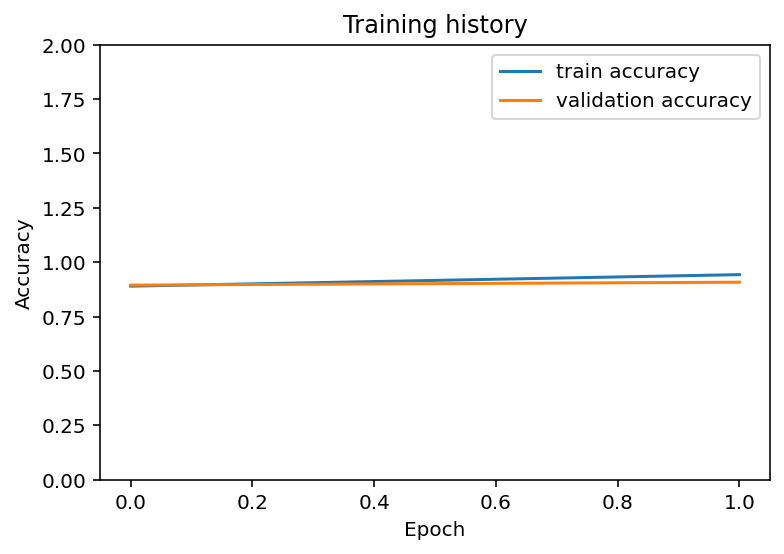

In [35]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2]);

In [36]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test)
)

test_acc.item()

0.8966666666666666

In [37]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["sents"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values


In [38]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [39]:
print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names]))

              precision    recall  f1-score   support

  contextual       0.88      0.92      0.90       445
      visual       0.92      0.87      0.90       455

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



In [57]:
model01 = DescriptionClassifier()
model01.to(device)

missing_keys, unexpected_keys = model01.load_state_dict(torch.load("best_model_state_9000.bin"))

y_texts1, y_pred1, y_pred_probs1, y_test1 = get_predictions(model01, test_data_loader)
print(classification_report(y_test1, y_pred1, target_names=[str(label) for label in class_names]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

  contextual       0.65      0.97      0.78       438
      visual       0.98      0.76      0.86       973

    accuracy                           0.83      1411
   macro avg       0.81      0.87      0.82      1411
weighted avg       0.88      0.83      0.83      1411



In [58]:
model02 = DescriptionClassifier()
model02.to(device)

missing_keys, unexpected_keys = model02.load_state_dict(torch.load("best_model_state_alldata.bin"))

y_texts2, y_pred2, y_pred_probs2, y_test2 = get_predictions(model02, test_data_loader)
print(classification_report(y_test2, y_pred2, target_names=[str(label) for label in class_names]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

  contextual       0.83      0.83      0.83       438
      visual       0.92      0.92      0.92       973

    accuracy                           0.90      1411
   macro avg       0.88      0.88      0.88      1411
weighted avg       0.90      0.90      0.90      1411



In [60]:
model03 = DescriptionClassifier()
model03.to(device)

missing_keys, unexpected_keys = model03.load_state_dict(torch.load("best_model_state1000.bin"))

y_texts3, y_pred3, y_pred_probs3, y_test3 = get_predictions(model03, test_data_loader)
print(classification_report(y_test3, y_pred3, target_names=[str(label) for label in class_names]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

  contextual       0.53      0.82      0.64       438
      visual       0.89      0.67      0.76       973

    accuracy                           0.72      1411
   macro avg       0.71      0.75      0.70      1411
weighted avg       0.78      0.72      0.73      1411



In [62]:
model04 = DescriptionClassifier()
model04.to(device)

missing_keys, unexpected_keys = model04.load_state_dict(torch.load("best_model_state1000_3000.bin"))

y_texts4, y_pred4, y_pred_probs4, y_test4 = get_predictions(model04, test_data_loader)
print(classification_report(y_test4, y_pred4, target_names=[str(label) for label in class_names]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

  contextual       0.58      0.61      0.59       438
      visual       0.82      0.80      0.81       973

    accuracy                           0.74      1411
   macro avg       0.70      0.70      0.70      1411
weighted avg       0.74      0.74      0.74      1411



In [75]:
model05 = DescriptionClassifier()
model05.to(device)

missing_keys, unexpected_keys = model05.load_state_dict(torch.load("best_model_state_9000.bin"))

y_texts5, y_pred5, y_pred_probs5, y_test5 = get_predictions(model05, test_data_loader)
print(classification_report(y_test5, y_pred5, target_names=[str(label) for label in class_names]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

              precision    recall  f1-score   support

  contextual       0.88      0.92      0.90       445
      visual       0.92      0.87      0.90       455

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900

